In [1]:
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torch.cuda.amp import GradScaler, autocast

import torch.nn.functional as F
from torch.nn import Conv2d, BatchNorm2d, ReLU, Sigmoid


if torch.cuda.is_available():
    print("CUDA is available. PyTorch is running on the GPU.")
    print("Device name:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available. PyTorch is running on the CPU.")

In [109]:
data_dir = '/vast/xj2173/diffeo/data/temp_inv_data/'

target_layer = '46'
data_name = data_dir + f'15-100-4-4-3-224-224_image-0001_activation_layer-{target_layer}.pt' 

# data[0] is the 0th picture, data[1] is the 1st picture, etc..
data = torch.load(data_name, map_location='cpu')
data.shape

torch.Size([1500, 1280, 7, 7])

In [110]:
import torch

# Assuming your tensor is named `data`
# data.shape is [1500, 48, 56, 56]

# Reshape each 56x56 image into a 48 x (56*56) matrix
reshaped_data = data.view(data.shape[0], data.shape[1], -1)  # Now each image is [1500, 48, 3136]

# Compute the correlation matrix for each image
correlation_matrices = []

for i in range(data.shape[0]):
    img = reshaped_data[i]  # shape [48, 3136]
    # Compute the correlation matrix for the channels
    correlation_matrix = torch.corrcoef(img)
    correlation_matrices.append(correlation_matrix)

# Convert list to tensor for easier handling later if needed
correlation_matrices = torch.stack(correlation_matrices)

# `correlation_matrices` is now a tensor of shape [1500, 48, 48]
# containing the correlation matrices for each image


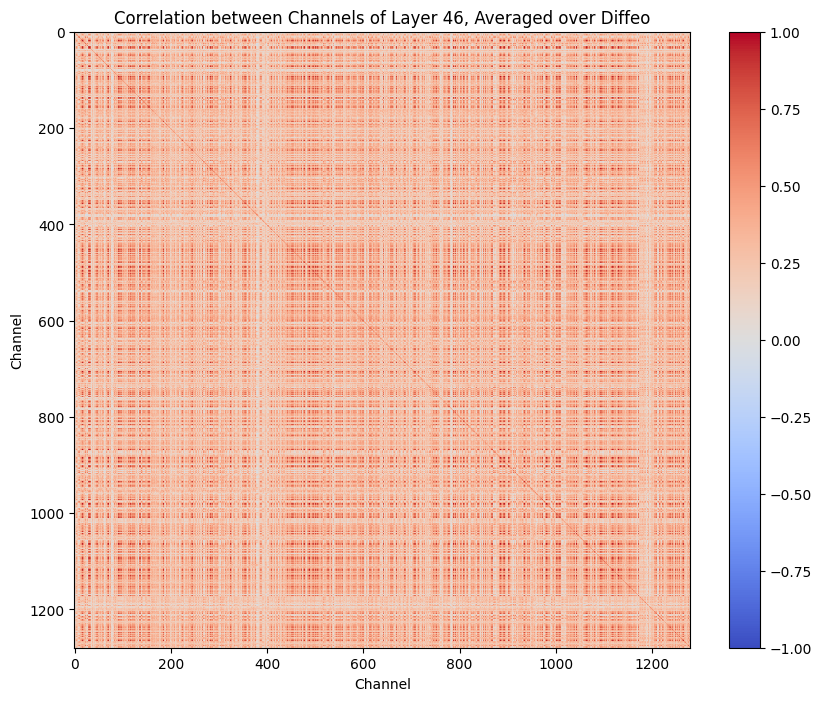

In [111]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Assuming `correlation_matrices` is the tensor from the previous step
# of shape [1500, 48, 48]

# Compute the mean correlation matrix across all images
mean_correlation_matrix = torch.mean(correlation_matrices, dim=0).numpy()

# Plotting the mean correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
plt.imshow(mean_correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.title(f'Correlation between Channels of Layer {target_layer}, Averaged over Diffeo')
plt.xlabel('Channel')
plt.ylabel('Channel')
plt.show()


In [112]:
import numpy as np
print('Avg:', round(np.mean(np.triu(mean_correlation_matrix, k=1)), 5))
print('Var:', round(np.var(np.triu(mean_correlation_matrix, k=1)),5))

Avg: 0.15293
Var: 0.0763


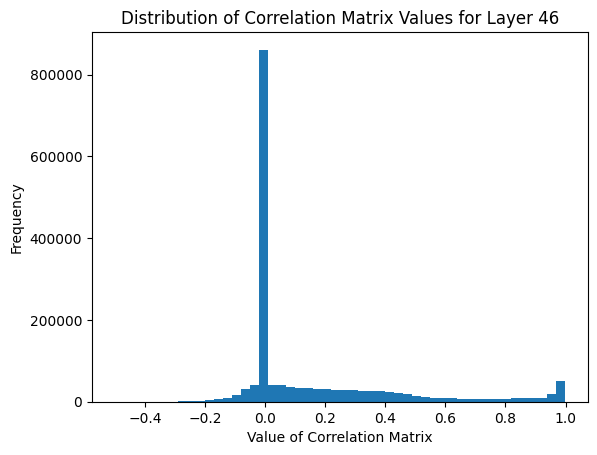

In [113]:
plt.hist(np.triu(mean_correlation_matrix, k=1).flatten(), bins=50)
plt.title(f'Distribution of Correlation Matrix Values for Layer {target_layer}')
plt.ylabel('Frequency')
plt.xlabel('Value of Correlation Matrix')
plt.show()

# How does this chnage over diffeo strength

In [58]:
data_dir = '/vast/xj2173/diffeo/data/temp_inv_data/'

target_layer = '43'
data_name = data_dir + f'15-100-4-4-3-224-224_image-0001_activation_layer-{target_layer}.pt' 

# data[0] is the 0th picture, data[1] is the 1st picture, etc..
data = torch.load(data_name, map_location='cpu')
data = data.reshape(15, 100, data.shape[1], data.shape[2], data.shape[2])
data.shape

torch.Size([15, 100, 256, 7, 7])

In [59]:
all = []

for data_per_strength in data:
    reshaped_data = data_per_strength.view(data_per_strength.shape[0], data_per_strength.shape[1], -1)  # Now each image is [1500, 48, 3136]
    correlation_matrices = []
    
    for i in range(data.shape[0]):
        img = reshaped_data[i]  # shape [48, 3136]
        # Compute the correlation matrix for the channels
        correlation_matrix = torch.corrcoef(img)
        correlation_matrices.append(correlation_matrix)
    
    # Convert list to tensor for easier handling later if needed
    correlation_matrices = torch.stack(correlation_matrices)
    mean_correlation_matrix = torch.mean(correlation_matrices, dim=0).numpy()

    all.append(mean_correlation_matrix)


all = np.array(all)
data = all


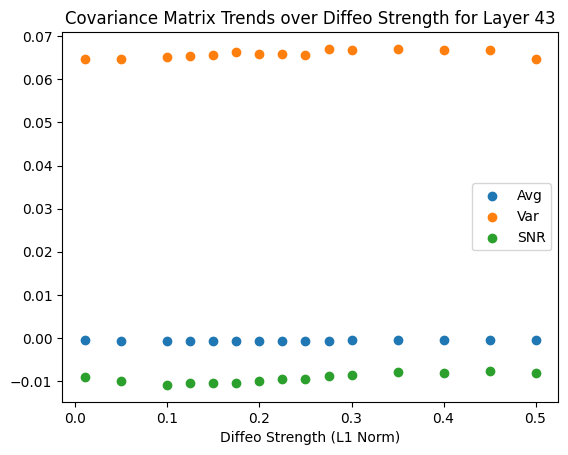

In [60]:
avg = np.array([round(np.mean(np.triu(d, k=1)), 5) for d in data])
var = np.array([round(np.var(np.triu(d, k=1)),5) for d in data])
snr = avg / var

plt.scatter(diffeo_strengths, avg, label='Avg')
plt.scatter(diffeo_strengths, var, label='Var')
plt.scatter(diffeo_strengths, snr, label='SNR')
plt.xlabel('Diffeo Strength (L1 Norm)')
plt.title(f'Covariance Matrix Trends over Diffeo Strength for Layer {target_layer}')
plt.legend()
plt.show()